In [1]:

# import various functions from sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from matplotlib.colors import ListedColormap


# import the XGBoost function for classification
from xgboost import XGBClassifier

In [2]:
#Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns',None)
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [15,8]

In [3]:
#reading the csv data 
df = pd.read_csv('train_indessa.csv')
df.head()
#The data contains 532428 rows and 45 columns.

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
0,58189336,14350,14350,14350.0,36 months,,19.19,E,E3,clerk,9 years,OWN,28700.0,Source Verified,n,NaN,debt_consolidation,Debt consolidation,349xx,FL,33.88,0.0,1.0,50.0,75.0,14.0,1.0,22515.0,73.1,28.0,f,1173.84,0.0,0.0,0.0,0.0,74.0,INDIVIDUAL,NaN,26th week,0.0,0.0,28699.0,30800.0,0
1,70011223,4800,4800,4800.0,36 months,BAT1586599,10.99,B,B4,Human Resources Specialist,< 1 year,MORTGAGE,65000.0,Source Verified,n,NaN,home_improvement,Home improvement,209xx,MD,3.64,0.0,1.0,NaN,NaN,6.0,0.0,7624.0,23.2,13.0,w,83.95,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,9974.0,32900.0,0
2,70255675,10000,10000,10000.0,36 months,BAT1586599,7.26,A,A4,Driver,2 years,OWN,45000.0,Not Verified,n,NaN,debt_consolidation,Debt consolidation,447xx,OH,18.42,0.0,0.0,NaN,NaN,5.0,0.0,10877.0,31.2,19.0,w,56.47,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,65.0,38295.0,34900.0,0
3,1893936,15000,15000,15000.0,36 months,BAT4808022,19.72,D,D5,Us office of Personnel Management,10+ years,RENT,105000.0,Not Verified,n,> My goal is to obtain a loan to pay off my hi...,debt_consolidation,Debt consolidation,221xx,VA,14.97,0.0,2.0,46.0,NaN,10.0,0.0,13712.0,55.5,21.0,f,4858.62,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,135th week,0.0,0.0,55564.0,24700.0,0
4,7652106,16000,16000,16000.0,36 months,BAT2833642,10.64,B,B2,LAUSD-HOLLYWOOD HIGH SCHOOL,10+ years,RENT,52000.0,Verified,n,NaN,credit_card,refi,900xx,CA,20.16,0.0,0.0,NaN,NaN,11.0,0.0,35835.0,76.2,27.0,w,2296.41,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,96th week,0.0,0.0,47159.0,47033.0,0


In [4]:
df1 = df.copy()

In [5]:
print('Number of nulls before',df.isnull().sum().sum())
print('Number of nulls before',df1.isnull().sum().sum())


Number of nulls before 2380715
Number of nulls before 2380715


1. verification_status_joint (% of null values is 99.92) 

2.  application_type  (biased towards the category 'individual')

3. mths_since_last_major_derog (mths_since_last_delinq and mths_since_last_major_derog have similar values and 
                               
   mths_since_last_major_derog null values % is 75% so the overall significant data is 10.28% only )       

4.  pymnt_plan (biased towards the category 'no')

5. desc (cant be used --sentence) 

6. zip_code  (Zip codes cant be converted or used due to extermly large number of unique values 
   instead we converted the addr_state) 

7.  batch_enrolled (too many unique categories) 

8.  member_id (unique values)

9. emp_title  (too many categories and some of them are not relevant)   

10. title (too many catergories and many irrelevant data )

11. mths_since_last_record (84.57% of null values)

In [6]:
df1 = df1.drop(['verification_status_joint','application_type','mths_since_last_major_derog','pymnt_plan','desc',
                'zip_code','batch_enrolled','member_id','emp_title','title','mths_since_last_record'] , axis = 1)

In [7]:
df1 = df1.drop(['home_ownership','purpose'],axis =1)

In [8]:
df1 = df1.dropna(subset=['delinq_2yrs'])

In [9]:
df1['last_week_pay'] = df1['last_week_pay'].replace('NAth week',None)
df1['last_week_pay'] = df1['last_week_pay'].fillna('0') # filling the null values with 0's
df1['last_week_pay'] = df1['last_week_pay'].str.extract('(\d+)') # Extract the numerical value in the string
df1['last_week_pay'] = df1['last_week_pay'].astype(int) # converting string to integer

In [10]:
dict = {'10+ years' : 10,
        '2 years'   : 2 ,
        '< 1 year'  : 0 ,
        '3 years'   : 3 ,
        '1 year'    : 1 ,
        '5 years'   : 5 ,
        '4 years'   : 4 ,
        '7 years'   : 7 ,
        '8 years'   : 8 ,
        '6 years'   : 6 ,
        '9 years'   : 9 }

df1['emp_length'] = df1.emp_length.map(dict) # converting the emp expiernce to numerical 
df1['emp_length'] = df1['emp_length'].fillna('0') # filling the null values with 0's
df1['emp_length'] = df1['emp_length'].astype(int)

In [11]:
# Classification of Address State
dic = {'S': ['DE', 'MD', 'VA', 'WV' ,'KY', 'NC' ,'SC','TN' ,'GA', 'FL' ,'AL' ,'MS' ,'AR' , 'LA', 'TX', 'OK','DC' ], 
       'W': ['WA', 'MT' , 'OR' , 'ID' ,'WY' , 'NV' ,'UT' ,'CO' ,'CA', 'AZ','NM', 'HI', 'AK' ],
       'MW' : ['ND','MN' , 'SD' ,'NE' ,'IA' ,'KS' , 'MO' , 'WI' , 'IL' , 'IN' ,'OH' ,'MI'],
       'NE' : ['PA', 'UT' ,'NH', 'ME','MA', 'RI' ,'CT' ,'NJ','NY','VT']}
# Dictionary for classifying regions according to their states

rep_df1 = []
for i in df1['addr_state']:
    for j,k in dic.items():
        if i in k:
            rep_df1.append(j)
            break
 
df1['addr_state'] = rep_df1

In [12]:
char = ['G', 'F', 'E', 'D', 'C', 'B', 'A']
    
for i ,j in zip(char , range(1,8)):
    df1['grade'].replace(i,j , regex = True , inplace = True)

df1['num'] = df1['sub_grade'].str[1] 
df1['num'] = df1['num'].astype(int)
rep = {5:1 , 4:2 ,3:3 ,2:4 , 1:5}
df1['num_inv'] = df1['num'].map(rep)
df1['grade_num'] = df1['grade'].astype(str) + df1['num_inv'].astype(str)
df1['grade_num'] = df1['grade_num'].astype(int)

df1 = df1.drop(['num','num_inv','grade','sub_grade'] , axis = 1)


# Converting the subgrades as :- 
                                    # A1,A2,A3,A4,A5 ------> 75,74,73,72,71
                                    # B1,B2,B3,B4,B5 ------> 65,64,63,62,61
                                    # C1,C2,C3,C4,C5 ------> 55,54,53,52,51
                                    # D1,D2,D3,D4,D5 ------> 45,44,43,42,41
                                    # E1,E2,E3,E4,E5 ------> 35,34,33,32,31
                                    # F1,F2,F3,F4,F5 ------> 25,24,23,22,21
                                    # G1,G2,G3,G4,G5 ------> 15,14,13,12,11

# respectively

In [13]:
df1['revol_util'] = df1['revol_util'].fillna(df1['revol_util'].median()) 
# revol_util the columns had 287 nulls and the data had high kurtosis so it was decide  
# to take median sine it wont affect the 5 lakh data set
df1['collections_12_mths_ex_med'] = df1['collections_12_mths_ex_med'].fillna(df1['collections_12_mths_ex_med'].median())
# collections_12_mths_ex_med majority of it was around 0,so median seemed ideal

In [14]:
df1['mths_since_last_delinq'] = df1['mths_since_last_delinq'].fillna(0)
# converting the null values to 0 

In [15]:
df1['tot_coll_amt'] = df1['tot_coll_amt'].fillna(df1['tot_coll_amt'].median())
df1['tot_cur_bal'] = df1['tot_cur_bal'].fillna(df1['tot_cur_bal'].median())
df1['total_rev_hi_lim'] = df1['total_rev_hi_lim'].fillna(df1['total_rev_hi_lim'].median())

In [16]:
y = df1.loan_status
X = df1.drop(['loan_status','delinq_2yrs','inq_last_6mths','pub_rec','collections_12_mths_ex_med' , 'acc_now_delinq'] , axis = 1)

In [17]:
X.std() # delinq_2yrs,inq_last_6mths,pub_rec,collections_12_mths_ex_med , acc_now_delinq have low std and therefore 
#their contribution significance is minimal

loan_amnt                    8434.335443
funded_amnt                  8429.050859
funded_amnt_inv              8441.070670
int_rate                        4.379613
emp_length                      3.806453
annual_inc                  65200.174864
dti                             8.368952
mths_since_last_delinq         22.881442
open_acc                        5.311442
revol_bal                   22423.360888
revol_util                     23.847374
total_acc                      11.843211
total_rec_int                2093.218920
total_rec_late_fee              4.088219
recoveries                    409.598013
collection_recovery_fee        63.079471
last_week_pay                  44.313456
tot_coll_amt                 1880.636498
tot_cur_bal                148571.220650
total_rev_hi_lim            36591.502495
grade_num                      12.974208
dtype: float64

In [18]:
df_num = df1.select_dtypes(exclude = 'object')
df_cat = df1.select_dtypes(include = 'object')

In [19]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
num_scaled = X_scaler.fit_transform(df_num)

In [20]:
df_num = pd.DataFrame(num_scaled,columns = df_num.columns)


In [21]:
X = pd.concat([df_num , df_cat], axis = 1)
#X = df1.drop(['loan_status'],axis = 1)
X.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status,grade_num,term,verification_status,addr_state,initial_list_status
0,-0.048364,-0.046814,-0.042097,1.357864,0.865087,-0.710585,1.880871,-0.365619,0.306308,1.458701,0.462098,1.379088,0.249437,0.756576,0.230735,-0.276907,-0.096546,-0.111593,-0.076976,-0.107502,-0.724270,-0.063386,-0.104603,-0.714885,-0.016934,-0.556265,-1.700245,36 months,Source Verified,S,f
1,-1.180641,-1.179801,-1.173471,-0.514449,-1.499322,-0.153837,-1.732488,-0.365619,0.306308,-0.726478,-1.044085,-0.333764,-0.414648,-1.335900,-1.035814,-0.797584,-0.096546,-0.111593,-0.076976,-0.107502,-1.107901,-0.063386,-0.104603,-0.840919,0.040456,-0.556265,0.534961,36 months,Source Verified,S,w
2,-0.564113,-0.562887,-0.557435,-1.366123,-0.973898,-0.460585,0.033565,-0.365619,-0.696676,-0.726478,-1.232358,-0.333764,-0.269576,-1.000433,-0.529195,-0.810712,-0.096546,-0.111593,-0.076976,-0.107502,-1.107901,-0.063386,-0.070040,-0.650296,0.095114,-0.556265,1.305721,36 months,Not Verified,MW,w
3,0.028702,0.030301,0.034908,1.478880,1.127799,0.459659,-0.378673,-0.365619,1.309293,1.283887,-0.290994,-0.333764,-0.143145,0.018548,-0.360321,1.483436,-0.096546,-0.111593,-0.076976,-0.107502,1.735482,-0.063386,-0.104603,-0.534063,-0.183640,-0.556265,-1.083637,36 months,Not Verified,S,f
4,0.147265,0.148938,0.153376,-0.594365,1.127799,-0.353223,0.241477,-0.365619,-0.696676,-0.726478,-0.102721,-0.333764,0.843461,0.886569,0.146299,0.259382,-0.096546,-0.111593,-0.076976,-0.107502,0.855387,-0.063386,-0.104603,-0.590635,0.426694,-0.556265,0.689113,36 months,Verified,W,w


In [22]:
LE = LabelEncoder()
X['term'] = LE.fit_transform(X['term'])


In [23]:
X['verification_status'] = LE.fit_transform(X['verification_status'])

In [24]:
X['initial_list_status'] = LE.fit_transform(X['initial_list_status'])

In [25]:
X = pd.get_dummies(data = X , columns = ['addr_state'], drop_first = True)

In [26]:
X.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status,grade_num,term,verification_status,initial_list_status,addr_state_NE,addr_state_S,addr_state_W
0,-0.048364,-0.046814,-0.042097,1.357864,0.865087,-0.710585,1.880871,-0.365619,0.306308,1.458701,0.462098,1.379088,0.249437,0.756576,0.230735,-0.276907,-0.096546,-0.111593,-0.076976,-0.107502,-0.724270,-0.063386,-0.104603,-0.714885,-0.016934,-0.556265,-1.700245,0,1,0,0,1,0
1,-1.180641,-1.179801,-1.173471,-0.514449,-1.499322,-0.153837,-1.732488,-0.365619,0.306308,-0.726478,-1.044085,-0.333764,-0.414648,-1.335900,-1.035814,-0.797584,-0.096546,-0.111593,-0.076976,-0.107502,-1.107901,-0.063386,-0.104603,-0.840919,0.040456,-0.556265,0.534961,0,1,1,0,1,0
2,-0.564113,-0.562887,-0.557435,-1.366123,-0.973898,-0.460585,0.033565,-0.365619,-0.696676,-0.726478,-1.232358,-0.333764,-0.269576,-1.000433,-0.529195,-0.810712,-0.096546,-0.111593,-0.076976,-0.107502,-1.107901,-0.063386,-0.070040,-0.650296,0.095114,-0.556265,1.305721,0,0,1,0,0,0
3,0.028702,0.030301,0.034908,1.478880,1.127799,0.459659,-0.378673,-0.365619,1.309293,1.283887,-0.290994,-0.333764,-0.143145,0.018548,-0.360321,1.483436,-0.096546,-0.111593,-0.076976,-0.107502,1.735482,-0.063386,-0.104603,-0.534063,-0.183640,-0.556265,-1.083637,0,0,0,0,1,0
4,0.147265,0.148938,0.153376,-0.594365,1.127799,-0.353223,0.241477,-0.365619,-0.696676,-0.726478,-0.102721,-0.333764,0.843461,0.886569,0.146299,0.259382,-0.096546,-0.111593,-0.076976,-0.107502,0.855387,-0.063386,-0.104603,-0.590635,0.426694,-0.556265,0.689113,0,2,1,0,0,1


In [27]:
X.isnull().sum()

loan_amnt                     16
funded_amnt                   16
funded_amnt_inv               16
int_rate                      16
emp_length                    16
annual_inc                    16
dti                           16
delinq_2yrs                   16
inq_last_6mths                16
mths_since_last_delinq        16
open_acc                      16
pub_rec                       16
revol_bal                     16
revol_util                    16
total_acc                     16
total_rec_int                 16
total_rec_late_fee            16
recoveries                    16
collection_recovery_fee       16
collections_12_mths_ex_med    16
last_week_pay                 16
acc_now_delinq                16
tot_coll_amt                  16
tot_cur_bal                   16
total_rev_hi_lim              16
loan_status                   16
grade_num                     16
term                           0
verification_status            0
initial_list_status            0
addr_state

In [28]:
X = X.drop(['loan_status'] , axis = 1)

In [29]:
X = X.dropna(axis = 0)

In [30]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [31]:
X = X.reset_index(drop = True)
y = y.reset_index(drop = True)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y , random_state = 10, test_size = 0.2)

In [33]:
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,grade_num,term,verification_status,initial_list_status,addr_state_NE,addr_state_S,addr_state_W
279906,0.526667,0.528578,0.532475,-0.930011,1.127799,0.843094,-0.150448,0.797112,0.306308,-0.070924,0.650371,-0.333764,0.060750,1.305903,-0.360321,-0.273788,-0.096546,-0.111593,-0.076976,-0.107502,-0.430905,-0.063386,-0.104603,4.707079,-0.276558,0.689113,1,2,0,0,1,0
479937,-0.326987,-0.325612,-0.320498,-1.809085,-1.236610,0.229598,-0.580610,-0.365619,-0.696676,2.026848,1.403463,-0.333764,0.856572,-1.138813,1.328412,-0.813971,-0.096546,-0.111593,-0.076976,-0.107502,-1.220733,-0.063386,-0.104603,-0.590433,2.674950,1.536950,0,0,0,0,0,0
319455,-0.979084,-0.978118,-0.972075,-1.153776,1.127799,0.030212,-0.700100,-0.365619,-0.696676,2.332773,0.085552,1.379088,-0.479357,-0.186925,1.159538,-0.621401,-0.096546,-0.111593,-0.076976,-0.107502,-0.137540,-0.063386,-0.104603,0.680925,-0.525249,1.228645,1,2,1,1,0,0
317931,1.433675,1.436154,1.438759,1.054184,1.127799,0.349229,-0.542374,-0.365619,0.306308,-0.726478,3.286193,-0.333764,0.598136,-0.254019,1.328412,0.445326,-0.096546,-0.111593,-0.076976,-0.107502,-0.521171,-0.063386,-0.104603,0.281924,0.832991,-1.083637,0,1,0,0,1,0
426404,0.028702,0.030301,0.034908,-1.512255,-0.448473,-0.118561,-0.584195,-0.365619,-0.696676,-0.726478,-0.290994,-0.333764,0.207338,1.268163,0.568482,-0.190361,-0.096546,-0.111593,-0.076976,-0.107502,0.945653,-0.063386,-0.104603,0.356595,-0.167243,1.459874,0,0,1,0,1,0


In [34]:
y_train = y_train.values.reshape(-1,1)

In [35]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)

# print dimension of test set
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (425929, 32)
y_train (425929, 1)
X_test (106483, 32)
y_test (106483,)


In [36]:
X_train = sm.add_constant(X_train)
logreg = sm.Logit(y_train,X_train).fit()
print(logreg.summary())

         Current function value: 0.462194
         Iterations: 35


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               425929
Model:                          Logit   Df Residuals:                   425896
Method:                           MLE   Df Model:                           32
Date:                Fri, 09 Sep 2022   Pseudo R-squ.:                  0.1547
Time:                        08:37:20   Log-Likelihood:            -1.9686e+05
converged:                      False   LL-Null:                   -2.3290e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -53.6068     43.829     -1.223      0.221    -139.510      32.296
loan_amnt                      2.9647      0.151     19.637      0.000       2.669 

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y , random_state = 10, test_size = 0.2)

In [38]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

logreg.score(X_test, y_test)

0.7805659119296038

In [39]:
df1.loan_status.value_counts()

0    406598
1    125814
Name: loan_status, dtype: int64

In [40]:

def rccr(model,x_train= X_train,x_test=X_test,y_train=y_train,y_test=y_test):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    y_train_pred = model.predict(x_train)
    print('test classification report ')
    print(classification_report(y_test,y_pred))
    print('train classification report ')
    print(classification_report(y_train,y_train_pred))
    print(confusion_matrix(y_test,y_pred))
    #plotting Roc curve
    fpr,tpr,threshold =roc_curve(y_test,y_pred)
    plt.plot(fpr,tpr)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.plot([0,1],[0,1])
    plt.title('ROC curve for Admission Prediction Classifier (Full Model)', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
    plt.text(x=0.8,y=0.2,s=('rocscore',roc_auc_score(y_test,y_pred)))
    plt.grid(True)


In [36]:
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve

test classification report 
              precision    recall  f1-score   support

           0       0.80      0.95      0.87     81326
           1       0.58      0.25      0.35     25157

    accuracy                           0.78    106483
   macro avg       0.69      0.60      0.61    106483
weighted avg       0.75      0.78      0.74    106483

train classification report 
              precision    recall  f1-score   support

           0       0.80      0.95      0.87    325272
           1       0.59      0.25      0.35    100657

    accuracy                           0.78    425929
   macro avg       0.69      0.60      0.61    425929
weighted avg       0.75      0.78      0.74    425929

[[76953  4373]
 [18993  6164]]


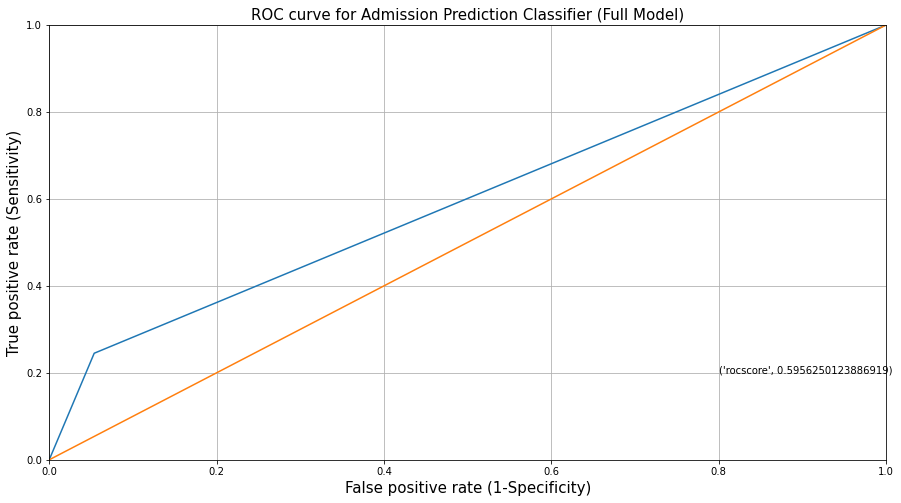

In [99]:
rccr( logreg)

In [100]:
from sklearn.tree import DecisionTreeClassifier
dtc_gini = DecisionTreeClassifier(criterion = 'gini',max_depth = 10,random_state = 10)
dtree_gini = dtc_gini.fit(X_train, y_train)
dtree_gini

DecisionTreeClassifier(max_depth=10, random_state=10)

test classification report 
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     81326
           1       0.90      0.40      0.55     25157

    accuracy                           0.85    106483
   macro avg       0.87      0.69      0.73    106483
weighted avg       0.85      0.85      0.82    106483

train classification report 
              precision    recall  f1-score   support

           0       0.84      0.99      0.91    325272
           1       0.91      0.40      0.55    100657

    accuracy                           0.85    425929
   macro avg       0.87      0.69      0.73    425929
weighted avg       0.86      0.85      0.82    425929

[[80205  1121]
 [15182  9975]]


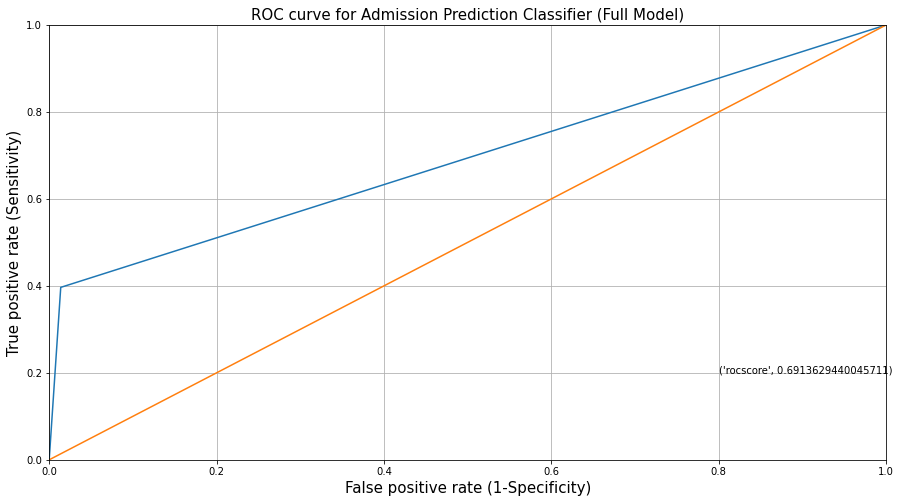

In [101]:
rccr(dtree_gini)

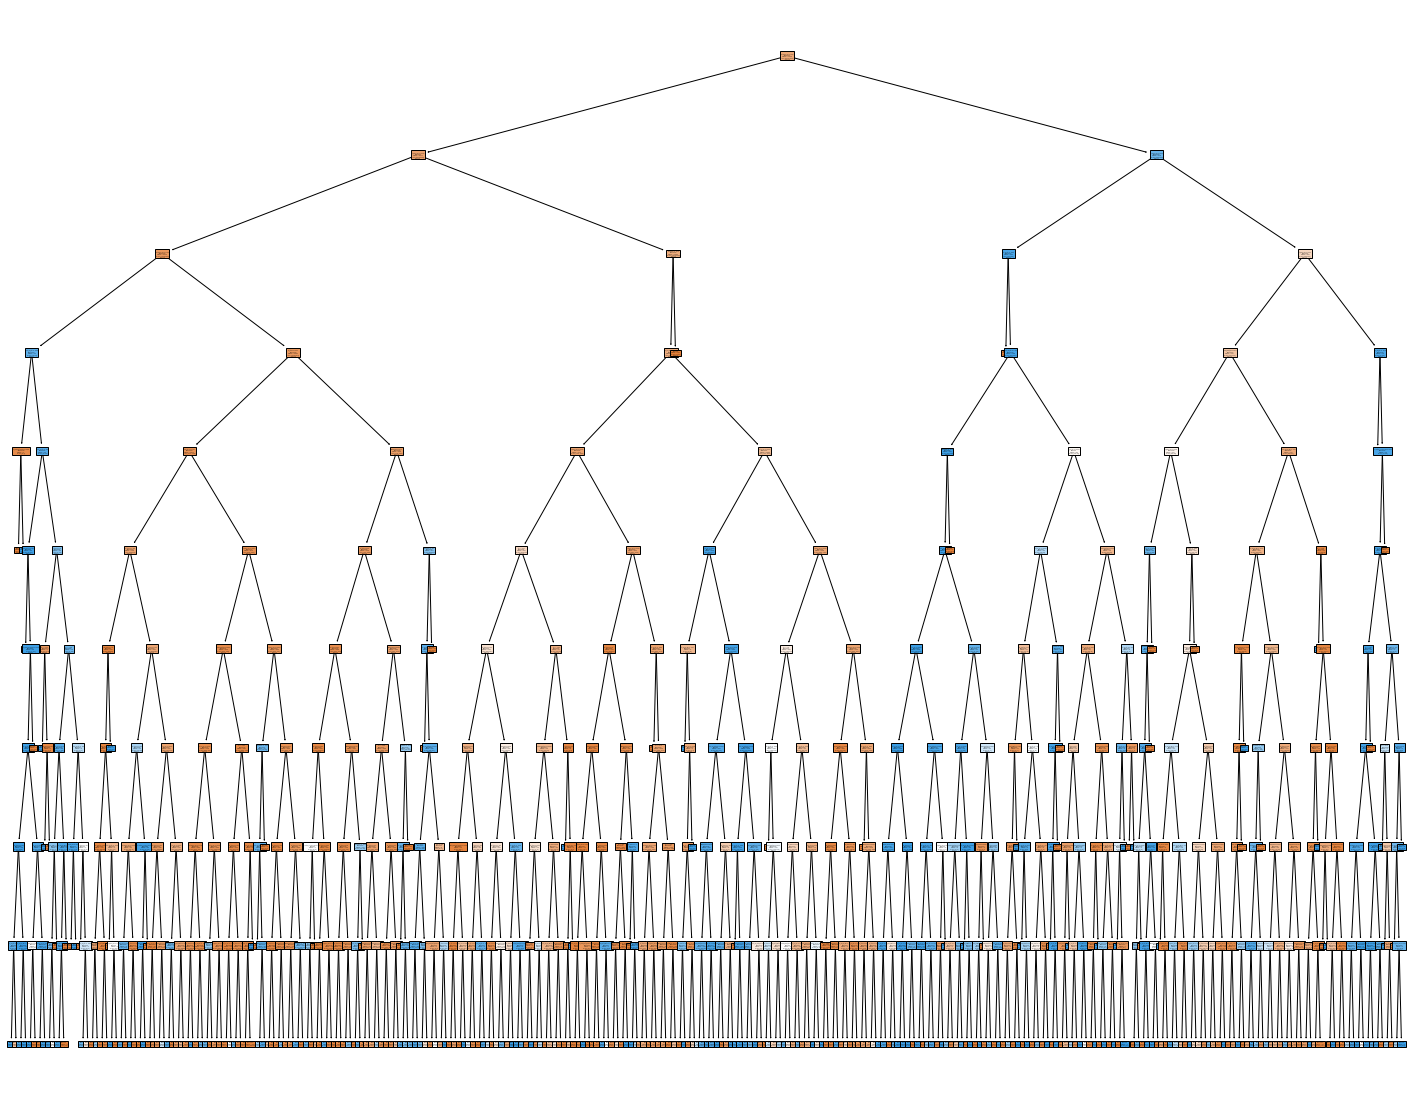

In [102]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtree_gini,
                   feature_names=X_train.columns,  
                   class_names=["0","1"],
                   filled=True)

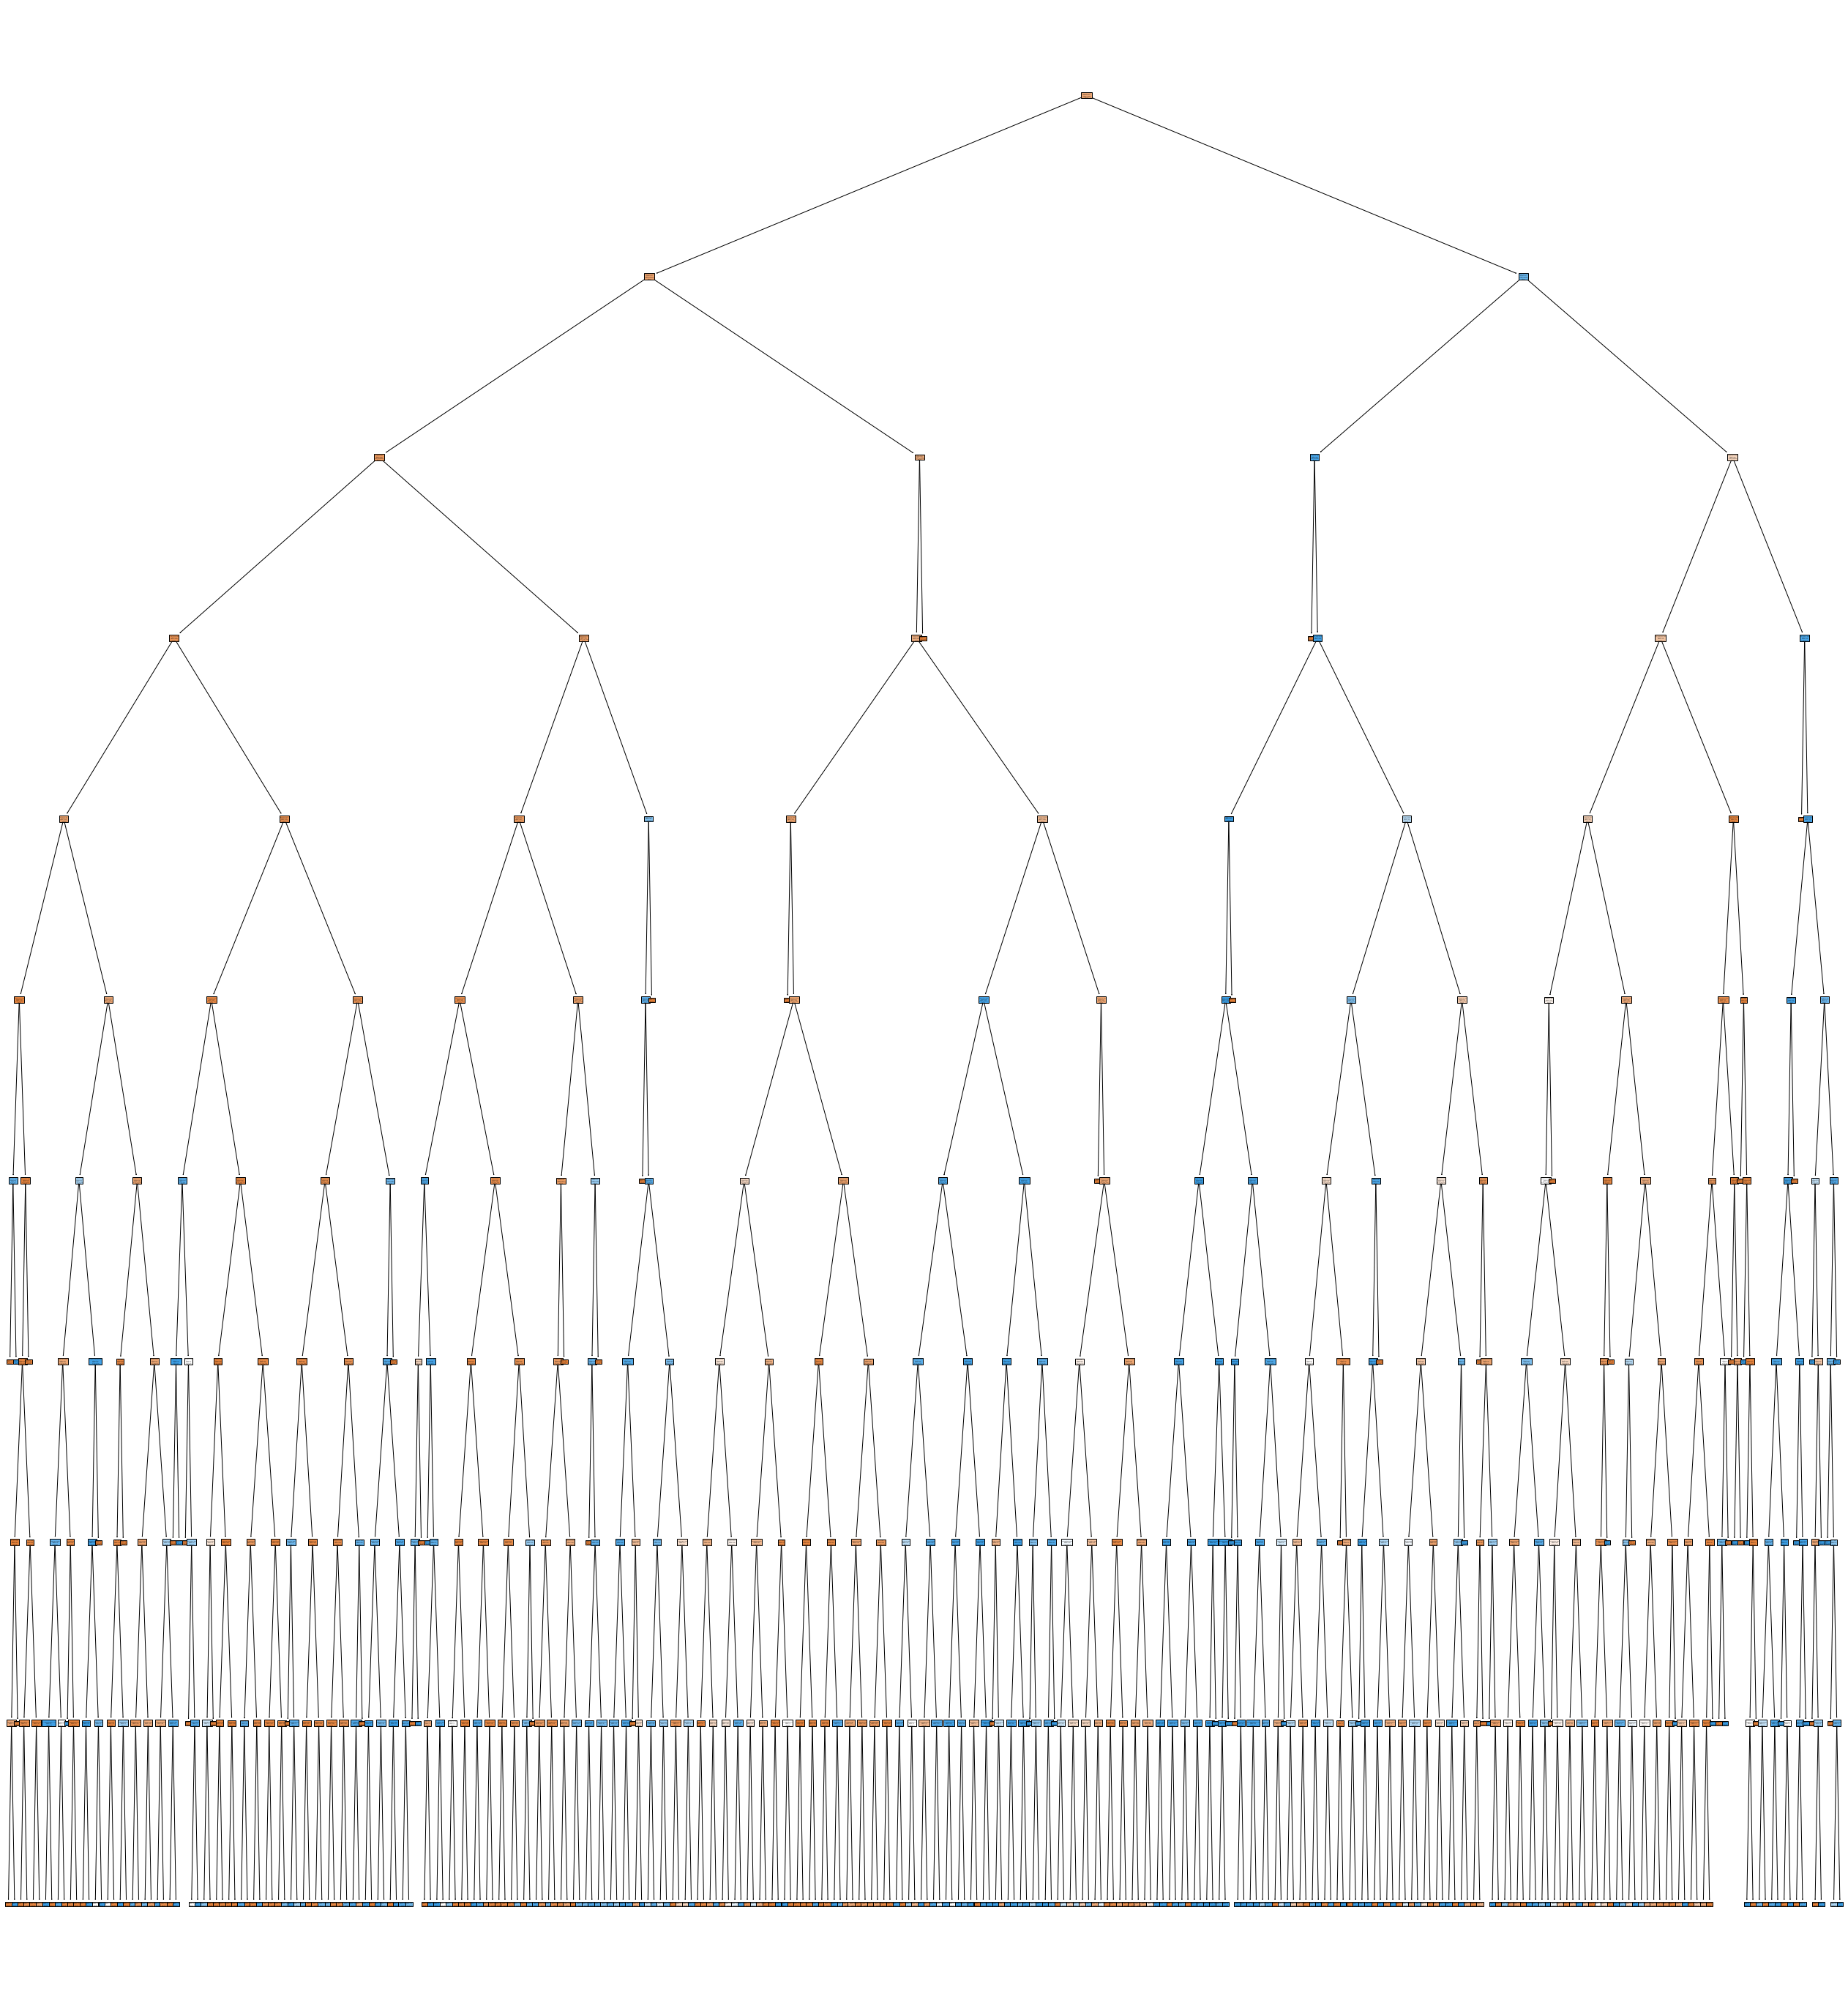

In [103]:
decision_tree_classification = DecisionTreeClassifier(criterion = 'entropy',max_depth = 10, random_state = 10)

# fit the model using fit() on train data
decision_tree = decision_tree_classification.fit(X_train, y_train)
fig = plt.figure(figsize=(45,50))
_ = tree.plot_tree(decision_tree,
                   feature_names=X_train.columns,  
                   class_names=["0","1"],
                   filled=True)

test classification report 
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     81326
           1       0.90      0.43      0.58     25157

    accuracy                           0.85    106483
   macro avg       0.87      0.71      0.75    106483
weighted avg       0.86      0.85      0.83    106483

train classification report 
              precision    recall  f1-score   support

           0       0.85      0.99      0.91    325272
           1       0.90      0.43      0.58    100657

    accuracy                           0.85    425929
   macro avg       0.88      0.71      0.75    425929
weighted avg       0.86      0.85      0.83    425929

[[80070  1256]
 [14360 10797]]


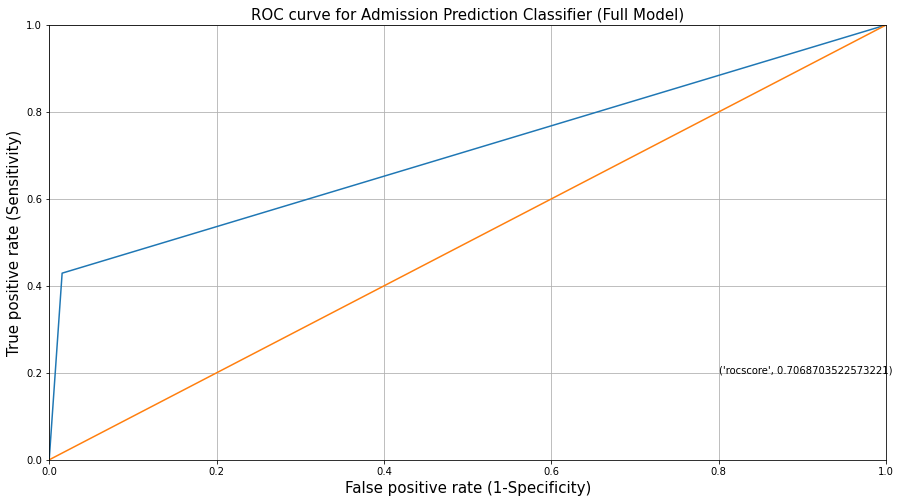

In [104]:
rccr(decision_tree_classification)

In [60]:
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier


In [37]:
from sklearn import metrics

In [38]:
def deviance(X ,y , model):
    return 2 * metrics.log_loss(y , model.predict_proba(X) , normalize = False)

In [107]:
deviance(X , y , logreg) #drop in deviance 

493087.12032200635

test classification report 
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     81326
           1       0.89      0.31      0.46     25157

    accuracy                           0.83    106483
   macro avg       0.86      0.65      0.68    106483
weighted avg       0.84      0.83      0.79    106483

train classification report 
              precision    recall  f1-score   support

           0       0.82      0.99      0.90    325272
           1       0.90      0.31      0.46    100657

    accuracy                           0.83    425929
   macro avg       0.86      0.65      0.68    425929
weighted avg       0.84      0.83      0.79    425929

[[80404   922]
 [17390  7767]]


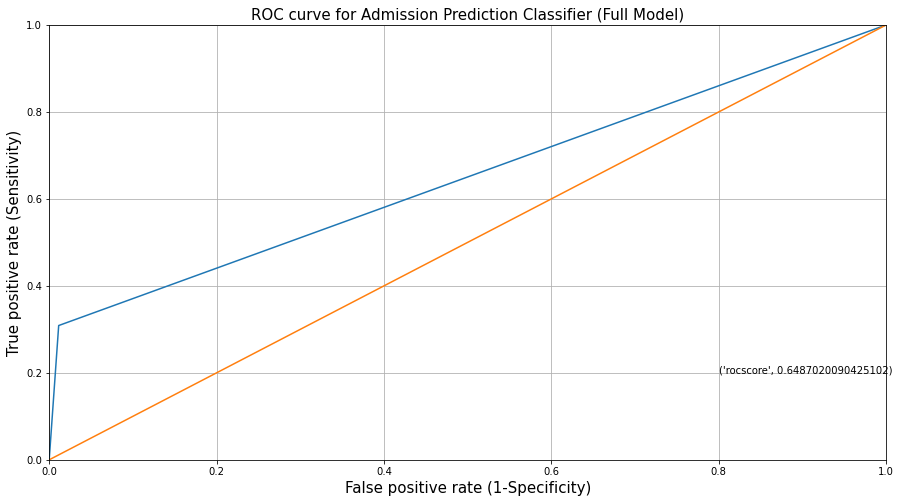

In [108]:
ada_model = AdaBoostClassifier(n_estimators = 33, random_state = 10)
rccr(ada_model)

      Iter       Train Loss   Remaining Time 
         1           1.0476           19.62s
         2           1.0179           15.03s
         3           0.9998           11.23s
         4           0.9845            7.38s
         5           0.9670            3.65s
         6           0.9563            0.00s
test classification report 
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     81326
           1       0.97      0.15      0.26     25157

    accuracy                           0.80    106483
   macro avg       0.88      0.58      0.57    106483
weighted avg       0.84      0.80      0.74    106483

train classification report 
              precision    recall  f1-score   support

           0       0.79      1.00      0.88    325272
           1       0.98      0.15      0.26    100657

    accuracy                           0.80    425929
   macro avg       0.88      0.57      0.57    425929
weighted avg       0.83     

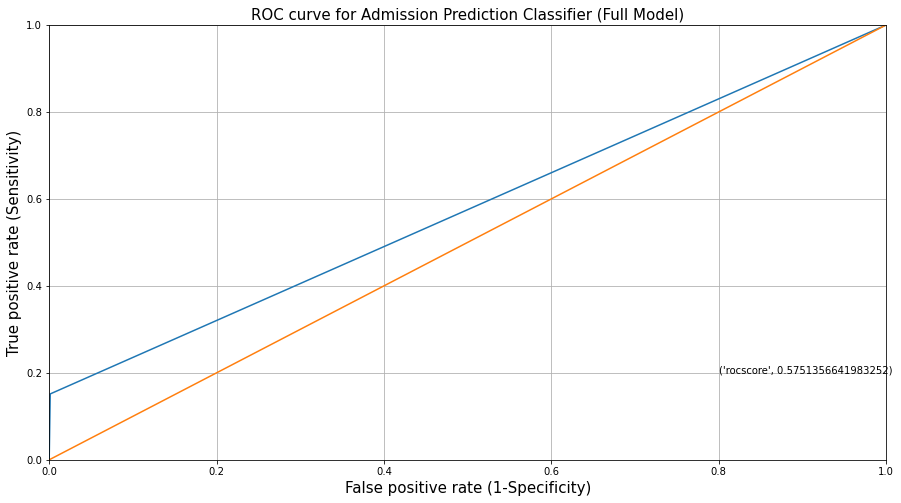

In [109]:
gboost_model = GradientBoostingClassifier(n_estimators = 6, max_depth = 5, random_state = 10, verbose=1)

rccr(gboost_model)

test classification report 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     81326
           1       0.90      0.75      0.82     25157

    accuracy                           0.92    106483
   macro avg       0.91      0.86      0.88    106483
weighted avg       0.92      0.92      0.92    106483

train classification report 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96    325272
           1       0.93      0.81      0.86    100657

    accuracy                           0.94    425929
   macro avg       0.94      0.89      0.91    425929
weighted avg       0.94      0.94      0.94    425929

[[79124  2202]
 [ 6281 18876]]


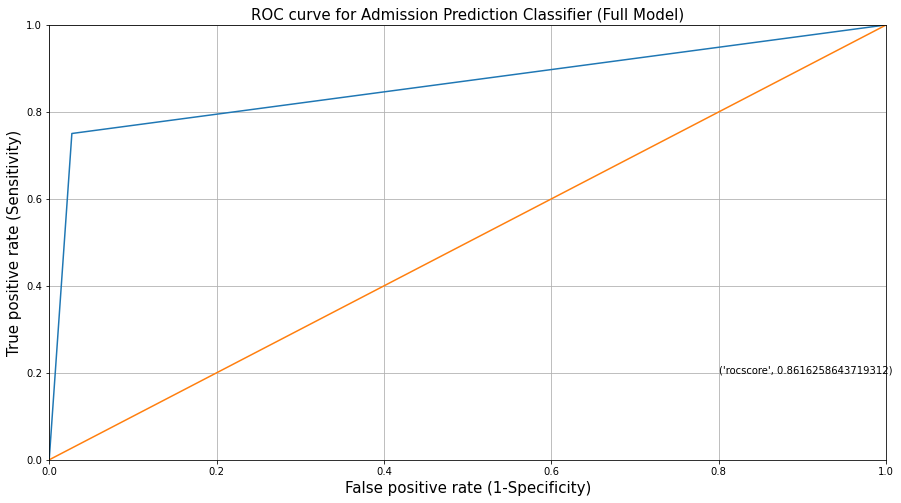

In [110]:
xgb_model = XGBClassifier(max_depth = 10, gamma = 1)

rccr(xgb_model)

In [ ]:
tuning_parameters = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                     'max_depth': range(3,10),
                     'gamma': [0, 1, 2, 3, 4]}

xgb_model = XGBClassifier()

xgb_grid = GridSearchCV(estimator = xgb_model, param_grid = tuning_parameters, cv = 3, scoring = 'roc_auc')

xgb_grid.fit(X_train, y_train)


In [ ]:
xgb_grid.best_params_

In [ ]:
xgb_model = XGBClassifier(gamma= 4, learning_rate = 0.3, max_depth = 9)

rccr(xgb_model)

In [36]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state = 42)
x_res,y_res = ros.fit_resample(X,y)
y_res.value_counts()

0    406598
1    406598
Name: loan_status, dtype: int64

In [37]:
from imblearn.over_sampling import SMOTE
sm =SMOTE(random_state= 2)
x_train_res,y_train_res = sm.fit_resample(X_train,y_train.ravel())


test classification report 
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     81326
           1       0.75      0.49      0.60     25157

    accuracy                           0.84    106483
   macro avg       0.81      0.72      0.75    106483
weighted avg       0.83      0.84      0.83    106483

train classification report 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    325272
           1       1.00      1.00      1.00    325272

    accuracy                           1.00    650544
   macro avg       1.00      1.00      1.00    650544
weighted avg       1.00      1.00      1.00    650544

[[77247  4079]
 [12759 12398]]


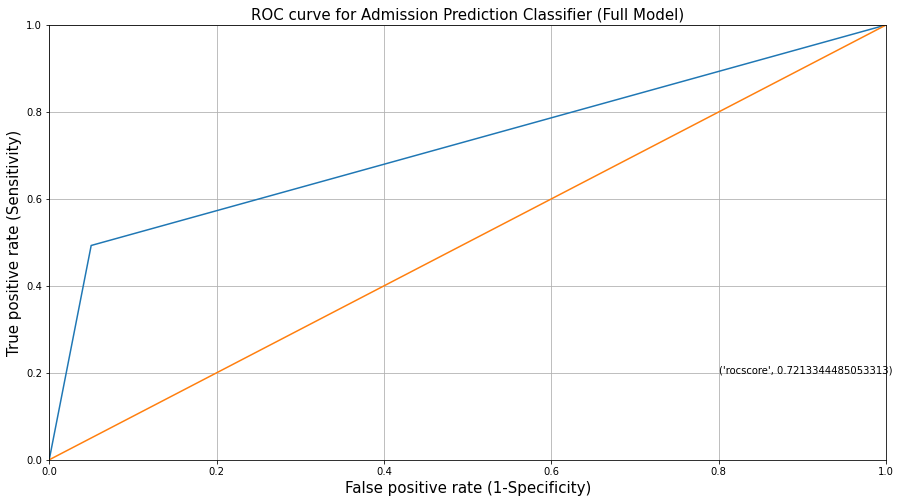

In [63]:
rfc = RandomForestClassifier( random_state= 10)
rccr1(rfc)

In [38]:

def rccr1(model,x_train= x_train_res,x_test=X_test,y_train=y_train_res,y_test=y_test):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    y_train_pred = model.predict(x_train)
    print('test classification report ')
    print(classification_report(y_test,y_pred))
    print('train classification report ')
    print(classification_report(y_train,y_train_pred))
    print(confusion_matrix(y_test,y_pred))
    #plotting Roc curve
    fpr,tpr,threshold =roc_curve(y_test,y_pred)
    plt.plot(fpr,tpr)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.plot([0,1],[0,1])
    plt.title('ROC curve for Admission Prediction Classifier (Full Model)', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
    plt.text(x=0.8,y=0.2,s=('rocscore',roc_auc_score(y_test,y_pred)))
    plt.grid(True)


In [39]:
print('X_train.shape',x_train_res.shape,'y_train.shape',y_train_res.shape)

X_train.shape (650544, 32) y_train.shape (650544,)


In [40]:
y_train_res[y_train_res==1].sum()
(y_train_res[y_train_res==0]).sum()

0

In [41]:
y_train_res=pd.DataFrame(y_train_res, columns=['loan status'])
y_train_res.value_counts()

loan status
0              325272
1              325272
dtype: int64

test classification report 
              precision    recall  f1-score   support

           0       0.87      0.73      0.80     81326
           1       0.43      0.66      0.52     25157

    accuracy                           0.72    106483
   macro avg       0.65      0.70      0.66    106483
weighted avg       0.77      0.72      0.73    106483

train classification report 
              precision    recall  f1-score   support

           0       0.73      0.73      0.73    325272
           1       0.73      0.73      0.73    325272

    accuracy                           0.73    650544
   macro avg       0.73      0.73      0.73    650544
weighted avg       0.73      0.73      0.73    650544

[[59594 21732]
 [ 8537 16620]]


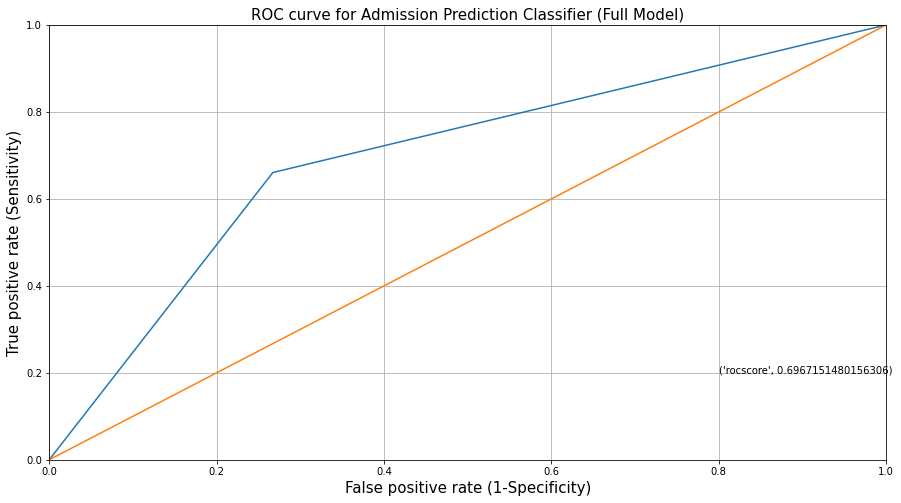

In [53]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train_res, y_train_res)

#logreg.score(X_test, y_test)
rccr1(logreg)

test classification report 
              precision    recall  f1-score   support

           0       0.86      0.74      0.80     81326
           1       0.42      0.60      0.49     25157

    accuracy                           0.71    106483
   macro avg       0.64      0.67      0.64    106483
weighted avg       0.75      0.71      0.72    106483

train classification report 
              precision    recall  f1-score   support

           0       0.73      0.74      0.74    325272
           1       0.74      0.72      0.73    325272

    accuracy                           0.73    650544
   macro avg       0.73      0.73      0.73    650544
weighted avg       0.73      0.73      0.73    650544

[[60357 20969]
 [10059 15098]]


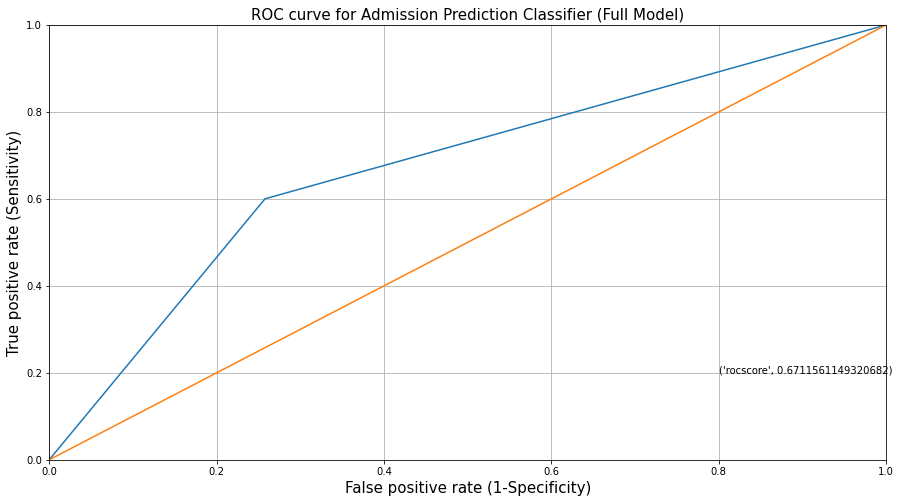

In [54]:
ada_model = AdaBoostClassifier(n_estimators = 33, random_state = 10)
ada_model.fit(x_train_res, y_train_res) 
rccr1(ada_model)

test classification report 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     81326
           1       0.87      0.75      0.80     25157

    accuracy                           0.91    106483
   macro avg       0.90      0.86      0.87    106483
weighted avg       0.91      0.91      0.91    106483

train classification report 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95    325272
           1       0.97      0.93      0.95    325272

    accuracy                           0.95    650544
   macro avg       0.95      0.95      0.95    650544
weighted avg       0.95      0.95      0.95    650544

[[78496  2830]
 [ 6389 18768]]


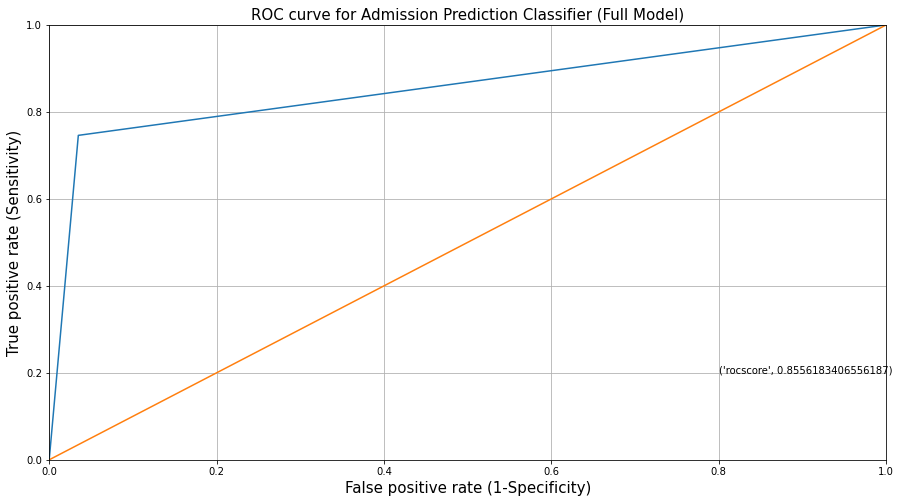

In [55]:
gboost_model = GradientBoostingClassifier(n_estimators = 100, learning_rate=0.6,max_depth = 7, random_state = 10)

# fit the model using fit() on train data
rccr1(gboost_model)

test classification report 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     81326
           1       0.89      0.75      0.81     25157

    accuracy                           0.92    106483
   macro avg       0.91      0.86      0.88    106483
weighted avg       0.92      0.92      0.92    106483

train classification report 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96    325272
           1       0.98      0.94      0.96    325272

    accuracy                           0.96    650544
   macro avg       0.96      0.96      0.96    650544
weighted avg       0.96      0.96      0.96    650544

[[78943  2383]
 [ 6317 18840]]


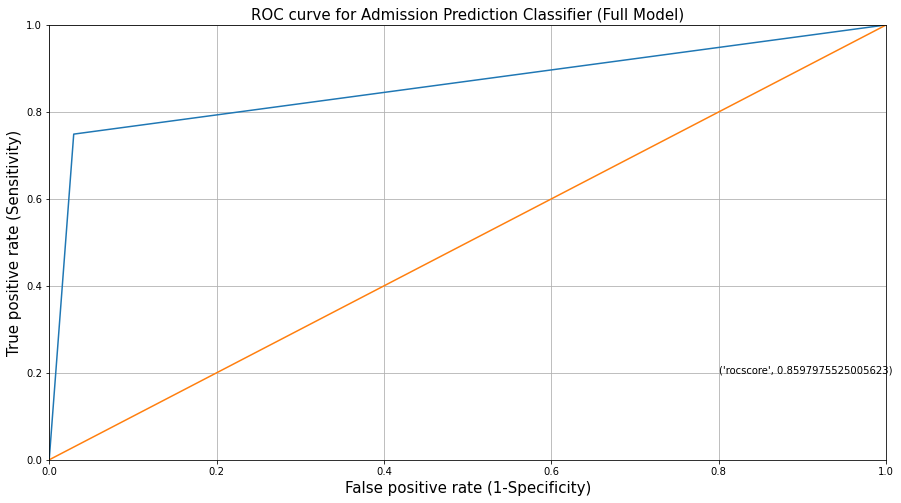

In [43]:
xgb_model = XGBClassifier(max_depth = 10, gamma = 1 ,random_state=10)

# fit the model using fit() on train data
rccr1(xgb_model)

test classification report 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     81326
           1       0.88      0.75      0.81     25157

    accuracy                           0.92    106483
   macro avg       0.90      0.86      0.88    106483
weighted avg       0.92      0.92      0.92    106483

train classification report 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    325272
           1       0.99      0.98      0.99    325272

    accuracy                           0.99    650544
   macro avg       0.99      0.99      0.99    650544
weighted avg       0.99      0.99      0.99    650544

[[78739  2587]
 [ 6196 18961]]


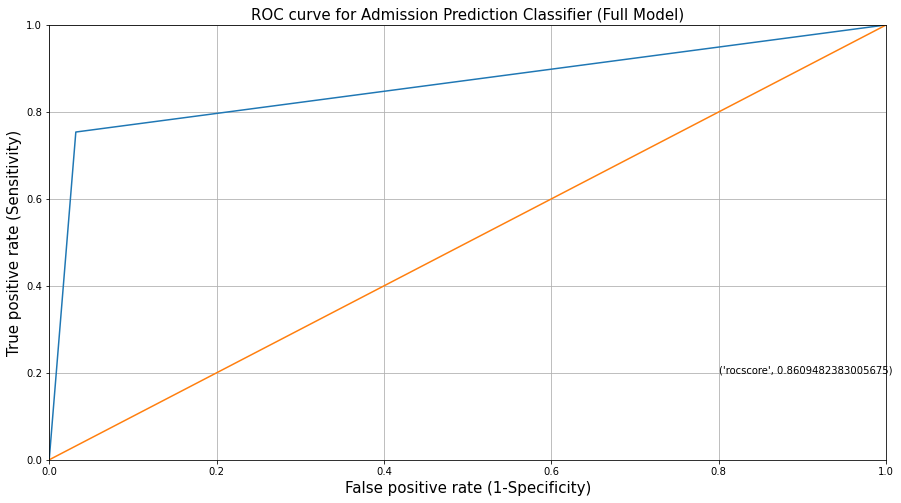

In [44]:
xgb_model = XGBClassifier(max_depth = 15, gamma = 1.5 ,random_state=10)

# fit the model using fit() on train data
rccr1(xgb_model)

test classification report 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     81326
           1       0.88      0.76      0.82     25157

    accuracy                           0.92    106483
   macro avg       0.91      0.86      0.88    106483
weighted avg       0.92      0.92      0.92    106483

train classification report 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    325272
           1       1.00      1.00      1.00    325272

    accuracy                           1.00    650544
   macro avg       1.00      1.00      1.00    650544
weighted avg       1.00      1.00      1.00    650544

[[78768  2558]
 [ 6014 19143]]


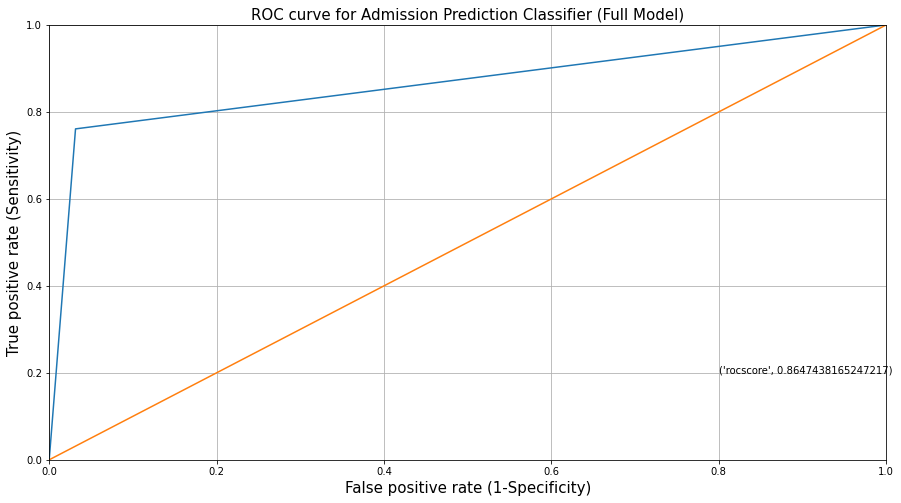

In [53]:
xgb_model = XGBClassifier(max_depth = 20, gamma = 1 ,random_state=10)

# fit the model using fit() on train data
rccr1(xgb_model)

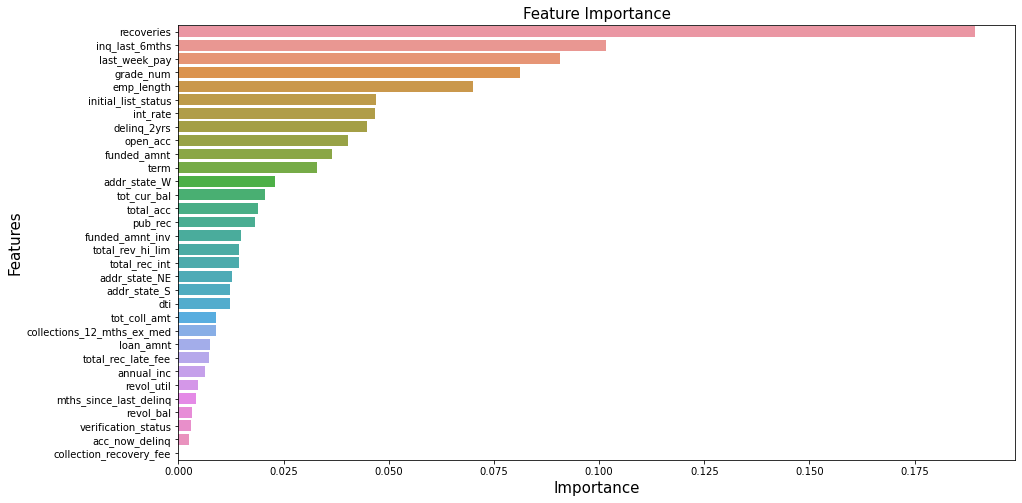

In [57]:
important_features = pd.DataFrame({'Features': x_train_res.columns, 
                                   'Importance': xgb_model.feature_importances_})


important_features = important_features.sort_values('Importance', ascending = False)

sns.barplot(x = 'Importance', y = 'Features', data = important_features)

plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)

plt.show()

In [182]:
tune={'n_estimators':[90,100],'learning_rate':[1.5]}
grid_ada = AdaBoostClassifier(random_state=10)


In [183]:
ada_grid = GridSearchCV(estimator = grid_ada, param_grid = tune, cv = 2, scoring = 'roc_auc')
ada_grid.fit(x_train_res, y_train_res)
ada_grid.best_params_

{'learning_rate': 1.5, 'n_estimators': 100}

test classification report 
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     81326
           1       0.57      0.62      0.59     25157

    accuracy                           0.80    106483
   macro avg       0.73      0.74      0.73    106483
weighted avg       0.81      0.80      0.80    106483

train classification report 
              precision    recall  f1-score   support

           0       0.82      0.86      0.84    325272
           1       0.85      0.81      0.83    325272

    accuracy                           0.83    650544
   macro avg       0.84      0.83      0.83    650544
weighted avg       0.84      0.83      0.83    650544

[[69836 11490]
 [ 9643 15514]]


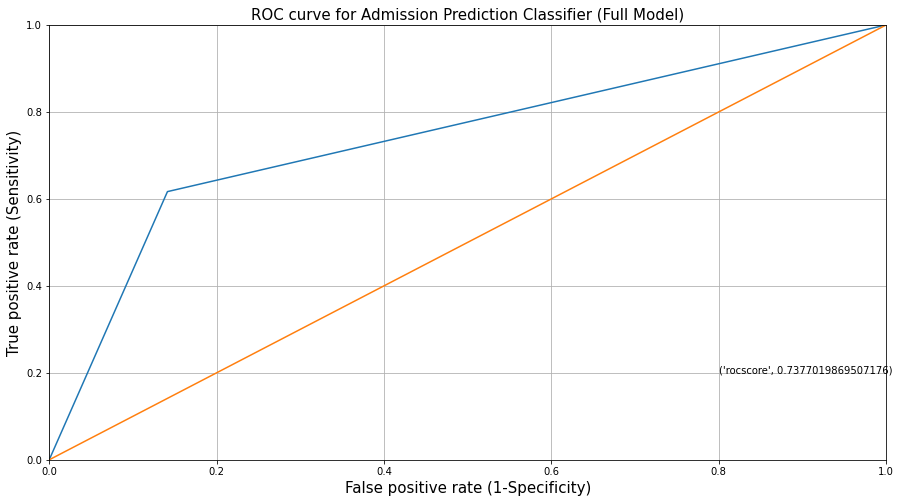

In [184]:
ada_model  = AdaBoostClassifier(n_estimators=ada_grid.best_params_['n_estimators'],
                                learning_rate=ada_grid.best_params_['learning_rate'],
                                random_state=10)
rccr1(ada_model)

In [ ]:
gb_n = GradientBoostingClassifier(random_state = 10)
tune_gb={'learning_rate':[1.5,1.6,1.7]}


In [ ]:
gb_grid = GridSearchCV(estimator = gb_n, param_grid = tune_gb, cv = 2, scoring = 'roc_auc')
gb_grid.fit(x_train_res, y_train_res)
gb_grid.best_params_

In [ ]:
gb_model  = GradientBoostingClassifier(
                                learning_rate=gb_grid.best_params_['learning_rate'],
                                random_state=10)
rccr1(gb_model)

In [47]:
from sklearn.cluster import DBSCAN
c=pd.concat([X, y],axis=1)
ones = c[c['loan_status']==1]

In [48]:
db =DBSCAN(eps=3.4,min_samples=45)

In [49]:
db.fit(ones)

DBSCAN(eps=3.4, min_samples=45)

In [50]:
(set(db.labels_))

{-1, 0, 1, 2}

In [51]:
ones['LAbels2_20']=db.labels_
ones['LAbels2_20'].value_counts()

 0    119559
-1      5211
 1       801
 2       243
Name: LAbels2_20, dtype: int64

In [52]:
ones[ones['LAbels2_20']==0].describe() 
#0 is the one with the largest cluster size it consists of 119559 rows
#here the recoveries are at -1.1159 *10^-1,
#inq_last_6mths has an average of 0.126078 ,
#last_week_pay has an average of 0.455547,
#grade_num average of 0.127482,
#emp_length of -0.024461

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,grade_num,term,verification_status,initial_list_status,addr_state_NE,addr_state_S,addr_state_W,loan_status,LAbels2_20
count,119559.000000,119559.000000,119559.000000,119559.000000,119559.000000,119559.000000,119559.000000,119559.000000,119559.000000,119559.000000,119559.000000,119559.000000,119559.000000,119559.000000,119559.000000,119559.000000,119559.000000,1.195590e+05,1.195590e+05,1.195590e+05,119559.000000,1.195590e+05,119559.000000,119559.000000,119559.000000,119559.000000,119559.000000,119559.000000,119559.000000,119559.000000,119559.000000,119559.000000,119559.0,119559.0
mean,-0.193522,-0.196721,-0.203152,-0.014603,-0.024461,-0.063722,-0.235545,-0.116868,0.126078,-0.047485,-0.137837,-0.103309,-0.123202,-0.079284,-0.030780,0.047009,-0.096537,-1.115932e-01,-7.697555e-02,-1.075015e-01,0.455547,-6.338625e-02,-0.074816,-0.093247,-0.111366,0.127482,0.267625,1.017121,0.427371,0.203598,0.350061,0.275671,1.0,0.0
std,0.932212,0.930458,0.932271,0.960346,0.976212,0.570985,0.916284,0.700349,1.060112,0.993504,0.888401,0.665380,0.566084,1.038287,0.972528,0.918791,0.002316,3.142083e-13,2.501065e-13,8.479364e-15,1.169339,1.362249e-13,0.202485,0.799549,0.525439,0.965340,0.442817,0.806440,0.494783,0.402675,0.476991,0.446854,0.0,0.0
min,-1.690463,-1.689942,-1.742120,-1.809085,-1.499322,-1.121688,-2.167429,-0.365619,-0.696676,-0.726478,-2.173723,-0.333764,-0.754651,-2.308754,-2.049054,-0.837690,-0.096546,-1.115932e-01,-7.697555e-02,-1.075015e-01,-1.311000,-6.338625e-02,-0.104603,-0.908052,-0.858661,-3.395919,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
25%,-0.919803,-0.918799,-0.912840,-0.706247,-0.973898,-0.460585,-0.917570,-0.365619,-0.696676,-0.726478,-0.855812,-0.333764,-0.497775,-0.845279,-0.782504,-0.544459,-0.096546,-1.115932e-01,-7.697555e-02,-1.075015e-01,-0.521171,-6.338625e-02,-0.104603,-0.639473,-0.407736,-0.312876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
50%,-0.365520,-0.384930,-0.391579,-0.044087,0.076951,-0.184512,-0.280692,-0.365619,-0.696676,-0.726478,-0.290994,-0.333764,-0.275106,-0.023385,-0.191448,-0.230223,-0.096546,-1.115932e-01,-7.697555e-02,-1.075015e-01,0.246091,-6.338625e-02,-0.104603,-0.365083,-0.210969,0.457885,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
75%,0.384392,0.386213,0.378466,0.583823,1.127799,0.183586,0.400398,-0.365619,0.306308,0.497223,0.273825,-0.333764,0.078566,0.739803,0.568482,0.297923,-0.096546,-1.115932e-01,-7.697555e-02,-1.075015e-01,1.329285,-6.338625e-02,-0.104603,0.202844,-0.025133,0.689113,1.000000,2.000000,1.000000,0.000000,1.000000,1.000000,1.0,0.0
max,2.399964,2.403049,2.404277,3.595507,1.127799,4.984191,4.660194,8.936229,7.327199,4.998691,5.922014,6.517644,5.644887,4.010606,5.550244,8.684620,0.693530,-1.115932e-01,-7.697555e-02,-1.075015e-01,5.458959,-6.338625e-02,5.252631,6.191472,5.708444,1.536950,2.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.0,0.0


In [54]:
ones[ones['LAbels2_20']==-1].describe()

#-1 is the outliers cluster size it consists of 5211 rows
#here the recoveries are at -1.1159 *10^-1,
#inq_last_6mths has an average of  0.879 ,
#last_week_pay has an average of 0.4127,
#grade_num average of -0.460,
#emp_length of 0.029156

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,grade_num,term,verification_status,initial_list_status,addr_state_NE,addr_state_S,addr_state_W,loan_status,LAbels2_20
count,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5.211000e+03,5.211000e+03,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.000000,5211.0,5211.0
mean,0.440669,0.433826,0.399282,0.460714,0.031980,1.154654,-0.341190,0.716116,0.891816,0.088652,0.430701,0.288135,1.160867,-0.213798,0.690300,0.620194,1.405601,-1.115932e-01,-7.697555e-02,0.664461,0.388753,0.841345,0.712491,0.988494,0.835276,-0.470371,0.301670,1.085780,0.448091,0.215506,0.355978,0.269814,1.0,-1.0
std,1.243716,1.242211,1.262601,1.121723,1.002390,3.053454,0.990037,2.272167,2.067971,1.022323,1.371065,1.715653,3.258627,1.242401,1.286658,1.596157,3.950727,8.882637e-16,2.026351e-15,2.581397,1.289351,3.547023,3.699604,2.276822,2.363009,1.230799,0.459027,0.803621,0.497346,0.411212,0.478854,0.443906,0.0,0.0
min,-1.690463,-1.689942,-1.742120,-1.809085,-1.499322,-1.042455,-2.167429,-0.365619,-0.696676,-0.726478,-1.985450,-0.333764,-0.754651,-2.308754,-1.880181,-0.837685,-0.096546,-1.115932e-01,-7.697555e-02,-0.107502,-1.311000,-0.063386,-0.104603,-0.908052,-0.858661,-3.395919,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-1.0
25%,-0.590790,-0.596995,-0.675903,-0.322651,-0.973898,-0.153837,-1.095609,-0.365619,-0.696676,-0.726478,-0.479267,-0.333764,-0.483371,-1.151393,-0.275885,-0.461876,-0.096546,-1.115932e-01,-7.697555e-02,-0.107502,-0.634004,-0.063386,-0.104603,-0.365083,-0.287489,-1.546093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-1.0
50%,0.339930,0.326894,0.248151,0.398874,0.076951,0.392174,-0.422884,-0.365619,0.306308,-0.376849,0.085552,-0.333764,-0.064834,-0.212085,0.484045,0.046041,-0.096546,-1.115932e-01,-7.697555e-02,-0.107502,0.065559,-0.063386,-0.104603,0.117962,-0.197304,-0.235800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,-1.0
75%,1.570023,1.572587,1.552785,1.209449,1.127799,1.456589,0.338861,0.797112,1.309293,0.672037,1.026917,-0.333764,1.298121,0.739803,1.497285,1.117105,-0.096546,-1.115932e-01,-7.697555e-02,-0.107502,1.239018,-0.063386,-0.104603,1.813063,0.973829,0.534961,1.000000,2.000000,1.000000,0.000000,1.000000,1.000000,1.0,-1.0
max,2.399964,2.403049,2.404277,3.481342,1.127799,92.407351,2.607367,25.214464,30.395839,5.872763,8.746108,18.507607,76.988719,35.108398,6.647920,10.043925,50.981869,-1.115932e-01,-7.697555e-02,37.487813,5.549226,63.134371,157.484744,52.938753,54.157798,1.536950,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.0,-1.0


In [55]:
ones[ones['LAbels2_20']==1].describe()
#1 is the outliers cluster size it consists of 801 rows
#here the recoveries are at -1.1159 *10^-1,
#inq_last_6mths has an average of  0.131005 ,
#last_week_pay has an average of 1.652372,
#grade_num average of 0.163437,
#emp_length of-0.331385

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,grade_num,term,verification_status,initial_list_status,addr_state_NE,addr_state_S,addr_state_W,loan_status,LAbels2_20
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,8.010000e+02,8.010000e+02,8.010000e+02,801.000000,8.010000e+02,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.0
mean,-0.819464,-0.820227,-0.851637,-0.101897,-0.331385,-0.358256,-0.402589,-0.158040,0.131005,-0.083964,-0.552366,-0.246090,-0.356032,0.001747,-0.600665,-0.114110,4.038822,-1.115932e-01,-7.697555e-02,-1.075015e-01,1.652372,-6.338625e-02,-0.098290,-0.375880,-0.279045,0.163437,0.243446,0.946317,0.323346,0.176030,0.354557,0.302122,1.0,1.0
std,0.495015,0.493566,0.499847,0.776652,0.914500,0.385710,0.883604,0.556824,0.943239,0.971004,0.719890,0.377709,0.374865,1.113616,0.744265,0.518460,0.881322,6.804365e-16,7.915281e-16,6.387771e-16,1.014399,2.360698e-16,0.056567,0.333038,0.209190,0.822659,0.429430,0.822110,0.468046,0.381084,0.478678,0.459465,0.0,0.0
min,-1.690463,-1.689942,-1.739158,-1.809085,-1.499322,-1.089418,-2.167429,-0.365619,-0.696676,-0.726478,-1.985450,-0.333764,-0.754651,-2.308754,-2.049054,-0.820821,3.438020,-1.115932e-01,-7.697555e-02,-1.075015e-01,-1.107901,-6.338625e-02,-0.104603,-0.907258,-0.817667,-2.625158,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,-1.186569,-1.185733,-1.244552,-0.594365,-1.236610,-0.613959,-1.060958,-0.365619,-0.696676,-0.726478,-1.044085,-0.333764,-0.613637,-0.799152,-1.204688,-0.503066,3.568013,-1.115932e-01,-7.697555e-02,-1.075015e-01,0.945653,-6.338625e-02,-0.104603,-0.365083,-0.325749,-0.235800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
50%,-0.860521,-0.859480,-0.912840,-0.057787,-0.448473,-0.414573,-0.419300,-0.365619,0.306308,-0.726478,-0.667540,-0.333764,-0.455186,0.064675,-0.698068,-0.244546,3.572537,-1.115932e-01,-7.697555e-02,-1.075015e-01,2.209379,-6.338625e-02,-0.104603,-0.365083,-0.210969,-0.004572,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
75%,-0.504832,-0.503568,-0.557435,0.453674,0.339663,-0.175310,0.248646,-0.365619,0.306308,0.409815,-0.102721,-0.333764,-0.209281,0.886569,-0.107011,0.168833,4.131095,-1.115932e-01,-7.697555e-02,-1.075015e-01,2.322212,-6.338625e-02,-0.104603,-0.365083,-0.210969,0.689113,0.000000,2.000000,1.000000,0.000000,1.000000,1.000000,1.0,1.0
max,0.621518,0.623488,0.627250,2.250638,1.127799,1.533276,2.554791,3.122574,3.315261,2.857216,2.344828,1.379088,1.951637,2.060704,2.426088,2.698212,8.586951,-1.115932e-01,-7.697555e-02,-1.075015e-01,4.669131,-6.338625e-02,1.060429,2.095682,1.245655,1.536950,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [56]:

ones[ones['LAbels2_20']==2].describe()
#2 is the outliers cluster size it consists of 243 rows
#here the recoveries are at -1.115932 *10^-1,
#inq_last_6mths has an average of  -0.2963,
#last_week_pay has an average of -0.237278,
#grade_num average of 0.00653,
#emp_length of 0.1245

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,grade_num,term,verification_status,initial_list_status,addr_state_NE,addr_state_S,addr_state_W,loan_status,LAbels2_20
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,243.000000,2.430000e+02,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.0,243.0
mean,-0.578580,-0.577362,-0.572304,0.087574,0.124520,-0.230018,-0.163474,0.112871,-0.296308,0.069179,-0.142235,-0.037715,-0.355303,-0.323045,-0.128207,-0.339777,-9.654565e-02,-1.115932e-01,-7.697555e-02,7.411561e+00,-0.237278,-6.338625e-02,0.100172,-0.303840,-0.292199,0.006530,0.275720,1.160494,0.460905,0.209877,0.407407,0.209877,1.0,2.0
std,0.473037,0.473334,0.472400,0.634379,0.971602,0.358382,0.936328,0.727922,0.598882,0.896941,0.719909,0.648981,0.253005,0.827778,0.720930,0.384117,3.615672e-16,1.390643e-16,6.953216e-17,4.806063e-14,0.668294,1.112515e-16,0.377903,0.600492,0.364682,0.602472,0.447799,0.751694,0.499498,0.408061,0.492366,0.408061,0.0,0.0
min,-1.560043,-1.559441,-1.552570,-1.541938,-1.499322,-0.796904,-2.058694,-0.365619,-0.696676,-0.726478,-1.797177,-0.333764,-0.723210,-2.145214,-1.457998,-0.825278,-9.654565e-02,-1.115932e-01,-7.697555e-02,7.411561e+00,-1.220733,-6.338625e-02,-0.104603,-0.898319,-0.820400,-1.083637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,2.0
25%,-0.921285,-0.920282,-0.914321,-0.286118,-0.711185,-0.491260,-0.885308,-0.365619,-0.696676,-0.726478,-0.667540,-0.333764,-0.545717,-0.950113,-0.698068,-0.611915,-9.654565e-02,-1.115932e-01,-7.697555e-02,7.411561e+00,-0.814536,-6.338625e-02,-0.076155,-0.760362,-0.543013,-0.274338,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,2.0
50%,-0.564113,-0.562887,-0.557435,0.095194,0.339663,-0.291874,-0.222142,-0.365619,-0.696676,-0.245738,-0.290994,-0.333764,-0.414469,-0.367239,-0.191448,-0.427732,-9.654565e-02,-1.115932e-01,-7.697555e-02,7.411561e+00,-0.318072,-6.338625e-02,-0.035477,-0.589215,-0.374941,-0.081648,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,2.0
75%,-0.318095,-0.316714,-0.311613,0.540440,1.127799,-0.046475,0.421308,0.797112,0.306308,0.584630,0.273825,-0.333764,-0.223909,0.309985,0.315172,-0.160350,-9.654565e-02,-1.115932e-01,-7.697555e-02,7.411561e+00,0.155825,-6.338625e-02,0.113940,0.019346,-0.131715,0.534961,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.0,2.0
max,0.858644,0.860763,0.864187,1.613595,1.127799,1.149841,1.981242,3.122574,1.309293,2.638698,2.721374,1.379088,0.543416,1.813297,1.835031,1.063135,-9.654565e-02,-1.115932e-01,-7.697555e-02,7.411561e+00,1.825748,-6.338625e-02,2.946495,1.778272,1.333107,1.459874,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.0,2.0


In [ ]:
db =DBSCAN(eps=1.5,min_samples=18)
db.fit(ones)
db.labels_

In [291]:
ones.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'emp_length',
       'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med',
       'last_week_pay', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'grade_num', 'term', 'verification_status',
       'initial_list_status', 'addr_state_NE', 'addr_state_S', 'addr_state_W',
       'loan_status', 'LAbels_1.5_21', 'LAbels_1.5_25'],
      dtype='object')

In [324]:
db =DBSCAN(eps=1.5,min_samples=21)
db.fit(ones)
(set(db.labels_))

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8}

<AxesSubplot:xlabel='loan_status', ylabel='acc_now_delinq'>

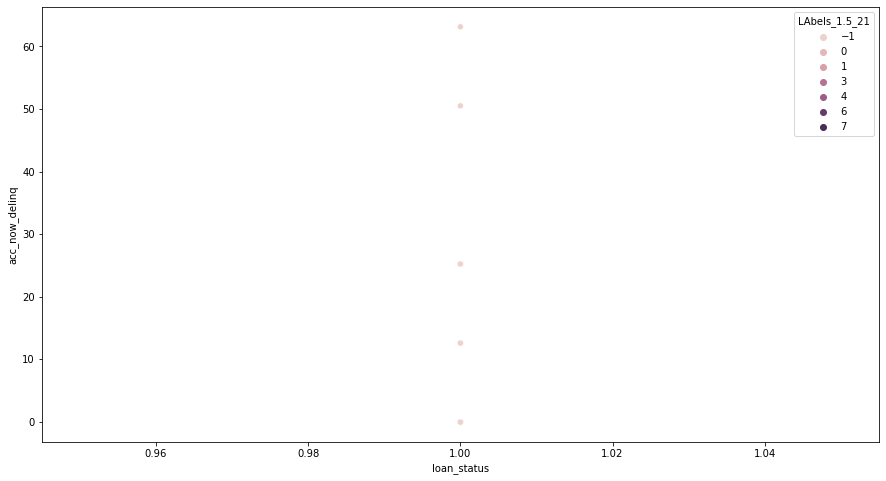

In [325]:
ones['LAbels_1.5_21']=db.labels_
sns.scatterplot(ones['loan_status'],ones['acc_now_delinq'],hue=ones['LAbels_1.5_21'])

In [323]:
ones[ones['LAbels_1.5_21']==3].describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,grade_num,term,verification_status,initial_list_status,addr_state_NE,addr_state_S,addr_state_W,loan_status,LAbels_1.5_21,LAbels_1.5_25
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,2.500000e+01,25.000000,2.500000e+01,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,2.500000e+01,2.500000e+01,25.000000,25.000000,2.500000e+01,25.000000,25.000000,25.000000,25.000000,25.00,25.000000,25.0,25.0,25.0,25.0,25.0,25.0,25.0
mean,-0.972919,-0.971948,-0.968757,-1.518648,-0.700677,-0.308356,-0.386225,-3.656187e-01,-0.576318,-7.264777e-01,-0.343710,-0.333764,-0.585916,-1.580623,-0.488665,-0.718391,-0.096546,-1.115932e-01,-7.697555e-02,-0.107502,-0.554569,-6.338625e-02,-0.087566,-0.557270,-0.215888,1.450624,0.04,0.080000,0.0,0.0,1.0,0.0,1.0,3.0,3.0
std,0.230998,0.231143,0.231709,0.164617,0.397555,0.273834,0.503914,1.133117e-16,0.332652,3.399350e-16,0.426290,0.000000,0.098361,0.433050,0.377707,0.080790,0.000000,2.832792e-17,2.832792e-17,0.000000,0.394329,2.832792e-17,0.085184,0.223368,0.202311,0.087088,0.20,0.276887,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,-1.334773,-1.334030,-1.327480,-1.786252,-1.499322,-0.698376,-1.254530,-3.656187e-01,-0.696676,-7.264777e-01,-1.232358,-0.333764,-0.735786,-2.212307,-1.204688,-0.826329,-0.096546,-1.115932e-01,-7.697555e-02,-0.107502,-1.220733,-6.338625e-02,-0.104603,-0.854683,-0.555311,1.305721,0.00,0.000000,0.0,0.0,1.0,0.0,1.0,3.0,3.0
25%,-1.156929,-1.156074,-1.149777,-1.646970,-0.973898,-0.460585,-0.700100,-3.656187e-01,-0.696676,-7.264777e-01,-0.667540,-0.333764,-0.653818,-1.893614,-0.782504,-0.769379,-0.096546,-1.115932e-01,-7.697555e-02,-0.107502,-0.814536,-6.338625e-02,-0.104603,-0.760163,-0.333948,1.382797,0.00,0.000000,0.0,0.0,1.0,0.0,1.0,3.0,3.0
50%,-1.038366,-1.037436,-1.031309,-1.541938,-0.711185,-0.353223,-0.431249,-3.656187e-01,-0.696676,-7.264777e-01,-0.290994,-0.333764,-0.596913,-1.704913,-0.529195,-0.716250,-0.096546,-1.115932e-01,-7.697555e-02,-0.107502,-0.634004,-6.338625e-02,-0.104603,-0.624215,-0.210969,1.459874,0.00,0.000000,0.0,0.0,1.0,0.0,1.0,3.0,3.0
75%,-0.896090,-0.895071,-0.889147,-1.393523,-0.448473,-0.184512,-0.091899,-3.656187e-01,-0.696676,-7.264777e-01,-0.102721,-0.333764,-0.539696,-1.310740,-0.191448,-0.677191,-0.096546,-1.115932e-01,-7.697555e-02,-0.107502,-0.227806,-6.338625e-02,-0.104603,-0.365083,-0.148112,1.536950,0.00,0.000000,0.0,0.0,1.0,0.0,1.0,3.0,3.0
max,-0.445550,-0.444249,-0.438966,-1.219992,0.076951,0.306285,0.633402,-3.656187e-01,0.306308,-7.264777e-01,0.462098,-0.333764,-0.311541,-0.673352,0.146299,-0.449379,-0.096546,-1.115932e-01,-7.697555e-02,-0.107502,0.155825,-6.338625e-02,0.321317,-0.080367,0.439456,1.536950,1.00,1.000000,0.0,0.0,1.0,0.0,1.0,3.0,3.0


In [321]:
ones[ones['LAbels_1.5_21']==0].describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,grade_num,term,verification_status,initial_list_status,addr_state_NE,addr_state_S,addr_state_W,loan_status,LAbels_1.5_21,LAbels_1.5_25
count,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1.096000e+03,1096.000000,1096.000000,1096.000000,1.096000e+03,1096.000000,1096.000000,1096.000000,1096.000000,1.096000e+03,1.096000e+03,1.096000e+03,1.096000e+03,1096.000000,1.096000e+03,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.00000,1096.000000,1096.000000,1096.000000,1096.000000,1096.0,1096.0,1096.0
mean,-0.758666,-0.762283,-0.772692,-0.733343,-0.620099,-0.481287,-0.375241,-3.656187e-01,-0.622550,-0.723248,-0.723540,-3.337637e-01,-0.335500,0.047056,-0.945908,-0.208403,-9.654565e-02,-1.115932e-01,-7.697555e-02,-1.075015e-01,1.958141,-6.338625e-02,-0.103465,-0.432526,-0.250991,0.862534,0.017336,0.42427,0.084854,0.033759,0.579380,0.286496,1.0,0.0,0.0
std,0.366415,0.362286,0.367526,0.591821,0.649567,0.263716,0.656027,2.887898e-15,0.265994,0.061708,0.443607,8.441547e-15,0.245267,0.940798,0.444740,0.310196,8.885839e-16,7.497427e-16,1.180150e-15,1.971546e-15,0.537818,1.249571e-16,0.021245,0.181518,0.128562,0.481534,0.130579,0.60870,0.278792,0.180691,0.493884,0.452330,0.0,0.0,0.0
min,-1.631181,-1.630623,-1.722285,-1.786252,-1.499322,-1.003529,-2.090956,-3.656187e-01,-0.696676,-0.726478,-1.797177,-3.337637e-01,-0.754651,-2.296174,-1.880181,-0.781489,-9.654565e-02,-1.115932e-01,-7.697555e-02,-1.075015e-01,-0.430905,-6.338625e-02,-0.104603,-0.883242,-0.776674,-0.852409,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
25%,-1.038366,-1.037436,-1.031309,-1.283924,-0.973898,-0.676540,-0.819888,-3.656187e-01,-0.696676,-0.726478,-1.044085,-3.337637e-01,-0.503718,-0.589486,-1.289124,-0.442910,-9.654565e-02,-1.115932e-01,-7.697555e-02,-1.075015e-01,1.825748,-6.338625e-02,-0.104603,-0.365083,-0.210969,0.612037,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
50%,-0.746404,-0.752706,-0.778082,-0.683414,-0.711185,-0.537272,-0.359555,-3.656187e-01,-0.696676,-0.726478,-0.667540,-3.337637e-01,-0.374779,0.123382,-0.951378,-0.266531,-9.654565e-02,-1.115932e-01,-7.697555e-02,-1.075015e-01,2.209379,-6.338625e-02,-0.104603,-0.365083,-0.210969,0.689113,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,1.0,0.0,0.0
75%,-0.564113,-0.562887,-0.557435,-0.256435,-0.185761,-0.342334,0.065230,-3.656187e-01,-0.696676,-0.726478,-0.479267,-3.337637e-01,-0.212347,0.848829,-0.613631,0.012186,-9.654565e-02,-1.115932e-01,-7.697555e-02,-1.075015e-01,2.231946,-6.338625e-02,-0.104603,-0.365083,-0.210969,1.305721,0.000000,1.00000,0.000000,0.000000,1.000000,1.000000,1.0,0.0,0.0
max,0.621518,0.501884,0.502858,0.695705,1.127799,0.689720,1.522403,-3.656187e-01,1.309293,0.497223,0.838644,-3.337637e-01,0.936623,1.788137,0.399608,0.907361,-9.654565e-02,-1.115932e-01,-7.697555e-02,-1.075015e-01,2.502744,-6.338625e-02,0.519123,0.834932,0.414860,1.536950,1.000000,2.00000,1.000000,1.000000,1.000000,1.000000,1.0,0.0,0.0


In [59]:
col1 = ['Logistic_reg_up_samp' , 'Decision_Tree_Base','Random_forest_down_samp' , 'Adaboost_Down_samp' , 'Gradient_Down_samp',
        'XGB_Down_samp']
row = ['Accuracy' , 'Precision' ,'recall' , 'f1_score']
df_scores = pd.DataFrame(columns = col1 , index = row)
df_scores

,Logistic_reg_up_samp,Decision_Tree_Base,Random_forest_down_samp,Adaboost_Down_samp,Gradient_Down_samp,XGB_Down_samp
Accuracy,NaN,NaN,NaN,NaN,NaN,NaN
Precision,NaN,NaN,NaN,NaN,NaN,NaN
recall,NaN,NaN,NaN,NaN,NaN,NaN
f1_score,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
df_scores['Logistic_reg_up_samp'] = [0.78, 0.58, 0.25, 0.35]
df_scores['Decision_Tree_Base'] = [0.85, 0.90 , 0.43 ,0.58]
df_scores['Random_forest_down_samp'] = [ 0.84,0.75 ,0.49 , 0.60]
df_scores['Adaboost_Down_samp'] = [0.80, 0.57,0.62, 0.59]
df_scores['Gradient_Down_samp']= [0.91,0.92, 0.97,0.94]
df_scores['XGB_Down_samp'] = [0.92,0.93, 0.97, 0.95]
df_scores

,Logistic_reg_up_samp,Decision_Tree_Base,Random_forest_down_samp,Adaboost_Down_samp,Gradient_Down_samp,XGB_Down_samp
Accuracy,0.78,0.85,0.84,0.80,0.91,0.92
Precision,0.58,0.90,0.75,0.57,0.92,0.93
recall,0.25,0.43,0.49,0.62,0.97,0.97
f1_score,0.35,0.58,0.60,0.59,0.94,0.95
